## Tutorial of using Mistral with this library

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/frankaging/align-transformers/blob/main/tutorials/Hook%20with%20new%20model%20and%20intervention%20types.ipynb)

In [1]:
__author__ = "Zhengxuan Wu and Ruixiang Cui"
__version__ = "10/05/2023"

### Overview

This library only supports a set of library as a priori. We allow users to add new model architectures to do intervention-based alignment training, and static path patching analyses. This tutorial shows how to deal with new model type that is not pre-defined in this library.

**Note that this tutorial will not add this new model type to our codebase. Feel free to open a PR to do that!**

In [2]:
try:
    # This library is our indicator that the required installs
    # need to be done.
    import transformers
    import sys
    sys.path.append("align-transformers/")
except ModuleNotFoundError:
    !git clone https://github.com/frankaging/align-transformers.git
    !pip install -r align-transformers/requirements.txt
    import sys
    sys.path.append("align-transformers/")

In [4]:
import sys
sys.path.append("..")

import torch
import pandas as pd
from models.constants import CONST_OUTPUT_HOOK
from models.configuration_alignable_model import AlignableRepresentationConfig, AlignableConfig
from models.alignable_base import AlignableModel
from models.interventions import Intervention, VanillaIntervention
from models.utils import lsm, sm, top_vals, format_token, type_to_module_mapping, \
    type_to_dimension_mapping, output_to_subcomponent_fn_mapping, \
    scatter_intervention_output_fn_mapping, simple_output_to_subcomponent, \
    simple_scatter_intervention_output

%config InlineBackend.figure_formats = ['svg']
from plotnine import ggplot, geom_tile, aes, facet_wrap, theme, element_text, \
                     geom_bar, geom_hline, scale_y_log10

### Try on new model type Mistral

In [5]:
def create_mistral(name="Open-Orca/Mistral-7B-OpenOrca", cache_dir="../../.huggingface_cache"):
    """Creates a mistral model, config, and tokenizer from the given name and revision"""
    from transformers import MistralForCausalLM, AutoTokenizer, MistralConfig
    
    config = MistralConfig.from_pretrained(name)
    tokenizer = AutoTokenizer.from_pretrained(name)
    mistral = MistralForCausalLM.from_pretrained(name, config=config, cache_dir=cache_dir)
    mistral.bfloat16()
    print("loaded model")
    return config, tokenizer, mistral

def embed_to_distrib_mistral(embed, log=False, logits=False):
    """Convert an embedding to a distribution over the vocabulary"""
    with torch.inference_mode():
        vocab = embed
        if logits:
            return vocab
        return lsm(vocab) if log else sm(vocab)

config, tokenizer, mistral = create_mistral()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

loaded model


In [38]:
base = "The capital of Spain is"
source = "The capital of Italy is"
inputs = [
    tokenizer(base, return_tensors="pt"),
    tokenizer(source, return_tensors="pt")
]
print(base)
res = mistral(**inputs[0])
distrib = embed_to_distrib_mistral(res.logits, logits=False)
top_vals(tokenizer, distrib[0][-1], n=10)
print()
print(source)
res = mistral(**inputs[1])
distrib = embed_to_distrib_mistral(res.logits, logits=False)
top_vals(tokenizer, distrib[0][-1], n=10)

The capital of Spain is
a                    0.20014575123786926
known                0.14642974734306335
Madrid               0.1292238086462021
one                  0.05734271928668022
full                 0.04753878340125084
not                  0.03267289698123932
an                   0.03267289698123932
famous               0.02109520696103573
also                 0.019817113876342773
renown               0.017488541081547737

The capital of Italy is


KeyboardInterrupt: 

### To add mistral, you only need the following block

In [4]:
# """Only define for the block output here for simplicity"""
# type_to_module_mapping[type(mistral)] = {
#     "mlp_output": ("encoder.block[%s].layer[1]", CONST_OUTPUT_HOOK),
#     "attention_input": ("encoder.block[%s].layer[0]", CONST_OUTPUT_HOOK),
# }
# type_to_dimension_mapping[type(mistral)] = {
#     "mlp_output": ("config.d_model", ),
#     "attention_input": ("config.d_model", ),
# }
# output_to_subcomponent_fn_mapping[type(mistral)] = simple_output_to_subcomponent           # no special subcomponent
# scatter_intervention_output_fn_mapping[type(mistral)] = simple_scatter_intervention_output # no special scattering

### Path patching with mistral

In [10]:
print(mistral.config)

MistralConfig {
  "_name_or_path": "Open-Orca/Mistral-7B-OpenOrca",
  "architectures": [
    "MistralForCausalLM"
  ],
  "bos_token_id": 1,
  "eos_token_id": 32000,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "max_position_embeddings": 32768,
  "model_type": "mistral",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "rms_norm_eps": 1e-05,
  "rope_theta": 10000.0,
  "sliding_window": 4096,
  "tie_word_embeddings": false,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.34.0",
  "use_cache": true,
  "vocab_size": 32002
}


In [39]:
def simple_position_config(model_type, intervention_type, layer):
    alignable_config = AlignableConfig(
        alignable_model_type=model_type,
        alignable_representations=[
            AlignableRepresentationConfig(
                layer,             # layer
                intervention_type, # intervention type
                "pos",             # intervention unit
                1                  # max number of unit
            ),
        ],
        alignable_interventions_type=VanillaIntervention,
    )
    return alignable_config
base = tokenizer("The capital of Spain is", return_tensors="pt")
sources = [tokenizer("The capital of Italy is", return_tensors="pt")]

In [39]:
import json
import numpy as np
from typing import List, Optional, Tuple, Union, Dict

from models.utils import *
import models.interventions
from models.constants import CONST_QKV_INDICES
        
        
class AlignableModel(nn.Module):
    """
    Generic alignable model. Alignments are specified in the config.
    """
    

    def __init__(
        self, 
        alignable_config,
        model
    ):
        super().__init__()
        # we allow one type intervention per alignment
        self.mode = alignable_config.mode
        intervention_type = alignable_config.alignable_interventions_type
        
        ###
        # We instantiate intervention_layers at locations.
        # Note that the layer name mentioned in the config is
        # abstract. Not the actual module name of the model.
        # 
        # This script will automatically convert abstract
        # name into module name if the model type is supported.
        #
        # To support a new model type, you need to provide a
        # mapping between supported abstract type and module name.
        ###
        self.alignable_representations = {}
        self.interventions = {}
        self._key_collision_counter = {}
        for representation in alignable_config.alignable_representations:
            intervention = intervention_type(
                get_alignable_dimension(model, representation),
                proj_dim=alignable_config.alignable_low_rank_dimension
            )
            alignable_module_hook = get_alignable_module_hook(model, representation)
            
            _key = self._get_representation_key(representation)
            self.alignable_representations[_key] = representation
            self.interventions[_key] = (intervention, alignable_module_hook)
        self.sorted_alignable_keys = sort_alignables_by_topological_order(
            model,
            self.alignable_representations
        )
        
        # model with cache activations
        self.activations = {}
        self.model = model
        self.model_config = model.config
        self.model_type = get_internal_model_type(model)
        self.disable_model_gradients()
        

    def __str__(self):
        """
        Print out basic info about this alignable instance
        """
        attr_dict = {
            "model_type": self.model_type,
            "alignable_interventions_type": self.alignable_interventions_type,
            "alignabls": self.sorted_alignable_keys,
            "mode": self.mode
        }
        return json.dumps(attr_dict, indent=4)


    def _get_representation_key(self, representation):
        """
        Provide unique key for each intervention
        """
        l = representation.alignable_layer
        r = representation.alignable_representation_type
        u = representation.alignable_unit
        n = representation.max_number_of_units
        key_proposal = f"layer.{l}.repr.{r}.unit.{u}.nunit.{n}"
        if key_proposal not in self._key_collision_counter:
            self._key_collision_counter[key_proposal] = 0
        else:
            self._key_collision_counter[key_proposal] += 1
        return f"{key_proposal}#{self._key_collision_counter[key_proposal]}"
    

    def get_cached_activations(self):
        """
        Return the cached activations with keys
        """
        return self.activations
                
    
    def set_temperature(self, temp: torch.Tensor):
        """
        Set temperature if needed
        """
        for k, v in self.interventions.items():
            if isinstance(
                v[0], 
                models.interventions.BoundlessRotatedSpaceIntervention
            ):
                v[0].set_temperature(temp)
    
    
    def disable_model_gradients(self):
        """
        Disable gradient in the model
        """
        # Freeze all model weights
        self.model.eval()
        for param in self.model.parameters():
            param.requires_grad = False
            

    def disable_intervention_gradients(self):
        """
        Disable gradient in the trainable intervention
        """
        # Freeze all intervention weights
        pass
        
    
    def set_device(self, device):
        """
        Set device of interventions and the model
        """
        for k, v in self.interventions.items():
            if isinstance(
                v[0], 
                models.interventions.TrainbleIntervention
            ):
                v[0].to(device)
        self.model.to(device)


    def count_parameters(self):
        """
        Set device of interventions and the model
        """
        total_parameters = 0
        for k, v in self.interventions.items():
            if isinstance(
                v[0], 
                models.interventions.TrainbleIntervention
            ):
                total_parameters += count_parameters(v[0])
        return total_parameters       
        
        
    def set_zero_grad(self):
        """
        Set device of interventions and the model
        """
        for k, v in self.interventions.items():
            if isinstance(
                v[0], 
                models.interventions.TrainbleIntervention
            ):
                v[0].zero_grad()

    
    def _gather_intervention_output(
        self, output,
        alignable_representations_key,
        unit_locations
    ) -> torch.Tensor:
        """
        Gather intervening activations from the output based on indices
        """
        original_output = output
        # data structure casting
        if isinstance(output, tuple):
            print("output is: ", output)
            original_output = output[0]
        # gather subcomponent
        original_output = self._output_to_subcomponent(
            original_output,
            alignable_representations_key
        )
        # gather based on intervention locations
        selected_output = gather_neurons(
            original_output,
            self.alignable_representations[
                alignable_representations_key].alignable_unit,
            unit_locations
        )
        return selected_output


    def _output_to_subcomponent(
        self, output, alignable_representations_key,
    ) -> List[torch.Tensor]:
        """
        Helps to get subcomponent of inputs/outputs of a hook
        
        For instance, we need to separate QKV from a hidden representation
        by slicing the original output
        """
        return output_to_subcomponent_fn_mapping[self.model_type](
            output, 
            self.alignable_representations[
                alignable_representations_key
            ].alignable_representation_type, 
            self.model_config
        )

    
    def _scatter_intervention_output(
        self, output, intervened_representation,
        alignable_representations_key,
        unit_locations
    ) -> torch.Tensor:
        """
        Scatter in the intervened activations in the output
        """
        original_output = output
        # data structure casting
        if isinstance(output, tuple):
            original_output = output[0]

        scatter_intervention_output_fn_mapping[self.model_type](
            original_output, intervened_representation, 
            self.alignable_representations[
                alignable_representations_key
            ].alignable_representation_type,
            unit_locations, self.model_config
        )
        return original_output
    

    def _intervention_getter(
        self, alignable_keys, unit_locations,
    ) -> HandlerList:  
        """
        Create a list of getter handlers that will fetch activations
        """
        handlers = []
        for key_i, key in enumerate(alignable_keys):
            _, alignable_module_hook = self.interventions[key]
            def hook_callback(model, input, output=None):
                selected_output = self._gather_intervention_output(
                    input if output is None else output, key, unit_locations[key_i]
                )
                self.activations[key] = selected_output
            handlers.append(alignable_module_hook(hook_callback))

        return HandlerList(handlers)
    
        
    def _intervention_setter(
        self, alignable_keys, unit_locations_source, 
        unit_locations_base
    ) -> HandlerList: 
        """
        Create a list of setter handlers that will set activations
        """
        handlers = []
        for key_i, key in enumerate(alignable_keys):
            intervention, alignable_module_hook = self.interventions[key]
            def hook_callback(model, input, output=None):
                if output is None:
                    # intervene in the module input with a pre forward hook
                    selected_output = self._gather_intervention_output(
                        input, key, unit_locations_base[key_i]
                    )
                    # intervene with cached activations
                    intervened_representation = do_intervention(
                        selected_output, self.activations[key], intervention)
                    # patched in the intervned activations
                    input = self._scatter_intervention_output(
                        input, intervened_representation,
                        key, unit_locations_base[key_i]
                    )
                else:
                    selected_output = self._gather_intervention_output(
                        output, key, unit_locations_base[key_i]
                    )
                    # intervene with cached activations
                    intervened_representation = do_intervention(
                        selected_output, self.activations[key], intervention)
                    # patched in the intervned activations
                    output = self._scatter_intervention_output(
                        output, intervened_representation,
                        key, unit_locations_base[key_i]
                    )
            handlers.append(alignable_module_hook(hook_callback))
            
        return HandlerList(handlers)
        
    
    def forward(
        self, 
        base,
        sources: Optional[List] = None,
        unit_locations: Optional[Dict] = None,
        activations_sources: Optional[Dict] = None,
    ):
        """
        Main forward function that serves a wrapper to
        actual model forward calls. It will use forward
        hooks to do interventions.

        In essense, sources will lead to getter hooks to
        get activations. We will use these activations to
        intervene on our base example.

        Parameters:
        base:                The base example.
        sources:             A list of source examples.
        unit_locations:      The intervention locations of
                             base.
        activations_sources: A list of representations.
        
        Return:
        base_output: the non-intervened output of the base
        input.
        counterfactual_outputs: the intervened output of the
        base input.
        """
        # if no source inputs, we are calling a simple forward
        if sources is None and activations_sources is None:
            return self.model(**base), None
        
        if sources is not None:
            assert len(sources) == len(self.sorted_alignable_keys)
        else:
            assert len(activations_sources) == len(self.sorted_alignable_keys)
            
        if self.mode == "parallel":
            assert "sources->base" in unit_locations
            unit_locations_sources = unit_locations["sources->base"][0]
            unit_locations_base = unit_locations["sources->base"][1]
            unit_locations_sources = np.array(unit_locations_sources)
            unit_locations_base = np.array(unit_locations_base)
            
            if unit_locations_base.shape != unit_locations_sources.shape:
                assert False, "In parallel mode, base intervention location"\
                              " has to be the same as the sources intervention"\
                              " locations"
        elif activations_sources is None and self.mode == "serial":
            assert "sources->base" not in unit_locations
            assert len(sources) == len(unit_locations)
            
        batch_size = base["input_ids"].shape[0]
        device = base["input_ids"].device
        # returning un-intervened output without gradients
        with torch.inference_mode():
            base_outputs = self.model(**base)
        
        all_set_handlers = HandlerList([])
        if self.mode == "parallel":
            # for each source, we hook in getters to cache activations
            # at each aligning representations
            if activations_sources is None:
                for key_i, alignable_key in enumerate(self.sorted_alignable_keys):
                    get_handlers = self._intervention_getter(
                        [alignable_key],
                        [torch.tensor(unit_locations_sources[key_i], device=device)],
                    )
                    _ = self.model(**sources[key_i])
                    get_handlers.remove()
            else:
                # simply patch in the ones passed in
                self.activations = activations_sources
                for key_i, alignable_key in enumerate(self.sorted_alignable_keys):
                    assert alignable_key in self.activations
                
            # in parallel mode, we swap cached activations all into
            # base at once
            for key_i, alignable_key in enumerate(self.sorted_alignable_keys):
                set_handlers = self._intervention_setter(
                    [alignable_key],
                    [torch.tensor(unit_locations_sources[key_i], device=device)],
                    [torch.tensor(unit_locations_base[key_i], device=device)],
                )
                # for setters, we don't remove them.
                all_set_handlers.extend(set_handlers)
            counterfactual_outputs = self.model(**base)
            all_set_handlers.remove()
            
        elif self.mode == "serial":
            for key_i, alignable_key in enumerate(self.sorted_alignable_keys):
                if key_i != len(self.sorted_alignable_keys)-1:
                    unit_locations_key = f"source_{key_i}->source_{key_i+1}"
                else:
                    unit_locations_key = f"source_{key_i}->base"

                unit_locations_source = \
                    unit_locations[unit_locations_key][0][0] # last one as only one intervention
                                                             # per source in serial case
                unit_locations_base = \
                    unit_locations[unit_locations_key][1][0]
                
                if activations_sources is None:
                    # get activation from source_i
                    get_handlers = self._intervention_getter(
                        [alignable_key],
                        [torch.tensor(unit_locations_source, device=device)],
                    )
                    _ = self.model(**sources[key_i])
                    get_handlers.remove()
                else:
                    self.activations[alignable_key] = activations_sources[alignable_key]
                    
                # set with intervened activation to source_i+1
                set_handlers = self._intervention_setter(
                    [alignable_key],
                    [torch.tensor(unit_locations_source, device=device)],
                    [torch.tensor(unit_locations_base, device=device)],
                )
                # for setters, we don't remove them.
                all_set_handlers.extend(set_handlers)
            counterfactual_outputs = self.model(**base)
            all_set_handlers.remove()
                
        return base_outputs, counterfactual_outputs
    

    def generate(
        self, 
        base,
        sources: Optional[List] = None,
        unit_locations: Optional[Dict] = None,
        activations_sources: Optional[Dict] = None,
        **kwargs
    ):
        """
        Intervenable generation function that serves a
        wrapper to regular model generate calls.

        Currently, we support basic interventions **in the
        prompt only**. We will support generation interventions
        in the next release.
        
        TODO: Unroll sources and intervene in the generation step.

        Parameters:
        base:                The base example.
        sources:             A list of source examples.
        unit_locations:      The intervention locations of
                             base.
        activations_sources: A list of representations.
        **kwargs:            All other generation parameters.
        
        Return:
        base_output: the non-intervened output of the base
        input.
        counterfactual_outputs: the intervened output of the
        base input.
        """
        # if no source inputs, we are calling a simple forward
        print("WARNING: This is a basic version that will "
              "intervene on some of the prompt token as well as "
              "the each generation step."
             )
        if sources is None and activations_sources is None:
            return self.model.generate(
                inputs=base["input_ids"],
                **kwargs
            ), None
        
        if sources is not None:
            assert len(sources) == len(self.sorted_alignable_keys)
        else:
            assert len(activations_sources) == len(self.sorted_alignable_keys)
            
        if self.mode == "parallel":
            assert "sources->base" in unit_locations
            unit_locations_sources = unit_locations["sources->base"][0]
            unit_locations_base = unit_locations["sources->base"][1]
            unit_locations_sources = np.array(unit_locations_sources)
            unit_locations_base = np.array(unit_locations_base)
            
            if unit_locations_base.shape != unit_locations_sources.shape:
                assert False, "In parallel mode, base intervention location"\
                              " has to be the same as the sources intervention"\
                              " locations"
        elif activations_sources is None and self.mode == "serial":
            assert "sources->base" not in unit_locations
            assert len(sources) == len(unit_locations)
            
        batch_size = base["input_ids"].shape[0]
        device = base["input_ids"].device
        # returning un-intervened output without gradients
        with torch.inference_mode():
            base_outputs = self.model.generate(
                inputs=base["input_ids"],
                **kwargs
            )
        
        all_set_handlers = HandlerList([])
        if self.mode == "parallel":
            # for each source, we hook in getters to cache activations
            # at each aligning representations
            if activations_sources is None:
                for key_i, alignable_key in enumerate(self.sorted_alignable_keys):
                    get_handlers = self._intervention_getter(
                        [alignable_key],
                        [torch.tensor(unit_locations_sources[key_i], device=device)],
                    )
                    _ = self.model(**sources[key_i])
                    get_handlers.remove()
            else:
                # simply patch in the ones passed in
                self.activations = activations_sources
                for key_i, alignable_key in enumerate(self.sorted_alignable_keys):
                    assert alignable_key in self.activations
                
            # in parallel mode, we swap cached activations all into
            # base at once
            for key_i, alignable_key in enumerate(self.sorted_alignable_keys):
                set_handlers = self._intervention_setter(
                    [alignable_key],
                    [torch.tensor(unit_locations_sources[key_i], device=device)],
                    [torch.tensor(unit_locations_base[key_i], device=device)],
                )
                # for setters, we don't remove them.
                all_set_handlers.extend(set_handlers)
            counterfactual_outputs = self.model.generate(
                inputs=base["input_ids"],
                **kwargs
            )
            all_set_handlers.remove()
            
        elif self.mode == "serial":
            for key_i, alignable_key in enumerate(self.sorted_alignable_keys):
                if key_i != len(self.sorted_alignable_keys)-1:
                    unit_locations_key = f"source_{key_i}->source_{key_i+1}"
                else:
                    unit_locations_key = f"source_{key_i}->base"

                unit_locations_source = \
                    unit_locations[unit_locations_key][0][0] # last one as only one intervention
                                                             # per source in serial case
                unit_locations_base = \
                    unit_locations[unit_locations_key][1][0]
                
                if activations_sources is None:
                    # get activation from source_i
                    get_handlers = self._intervention_getter(
                        [alignable_key],
                        [torch.tensor(unit_locations_source, device=device)],
                    )
                    _ = self.model(**sources[key_i])
                    get_handlers.remove()
                else:
                    self.activations[alignable_key] = activations_sources[alignable_key]
                    
                # set with intervened activation to source_i+1
                set_handlers = self._intervention_setter(
                    [alignable_key],
                    [torch.tensor(unit_locations_source, device=device)],
                    [torch.tensor(unit_locations_base, device=device)],
                )
                # for setters, we don't remove them.
                all_set_handlers.extend(set_handlers)
            counterfactual_outputs = self.model.generate(
                inputs=base["input_ids"],
                **kwargs
            )
            all_set_handlers.remove()
                
        return base_outputs, counterfactual_outputs
    


In [40]:
mistral.config.num_hidden_layers

32

In [59]:
def remove_forward_hooks(main_module: nn.Module):
    """Function to remove all forward and pre-forward hooks from a module and its sub-modules."""
    # Remove forward hooks
    for _, submodule in main_module.named_modules():
        if hasattr(submodule, "_forward_hooks"):
            hooks = list(submodule._forward_hooks.keys()) 
            print(hooks)# Get a list of hook IDs
            for hook_id in hooks:
                submodule._forward_hooks.pop(hook_id)

        # Remove pre-forward hooks
        if hasattr(submodule, "_forward_pre_hooks"):
            pre_hooks = list(submodule._forward_pre_hooks.keys()) 
            print(pre_hooks)# Get a list of pre-hook IDs
            for pre_hook_id in pre_hooks:
                submodule._forward_pre_hooks.pop(pre_hook_id)

remove_forward_hooks(mistral)

In [48]:
import json
import numpy as np
from typing import List, Optional, Tuple, Union, Dict

from models.utils import *
import models.interventions
from models.constants import CONST_QKV_INDICES
        
        
class AlignableModel(nn.Module):
    """
    Generic alignable model. Alignments are specified in the config.
    """
    

    def __init__(
        self, 
        alignable_config,
        model
    ):
        super().__init__()
        # we allow one type intervention per alignment
        self.mode = alignable_config.mode
        intervention_type = alignable_config.alignable_interventions_type
        
        ###
        # We instantiate intervention_layers at locations.
        # Note that the layer name mentioned in the config is
        # abstract. Not the actual module name of the model.
        # 
        # This script will automatically convert abstract
        # name into module name if the model type is supported.
        #
        # To support a new model type, you need to provide a
        # mapping between supported abstract type and module name.
        ###
        self.alignable_representations = {}
        self.interventions = {}
        self._key_collision_counter = {}
        for representation in alignable_config.alignable_representations:
            intervention = intervention_type(
                get_alignable_dimension(model, representation),
                proj_dim=alignable_config.alignable_low_rank_dimension
            )
            alignable_module_hook = get_alignable_module_hook(model, representation)
            
            _key = self._get_representation_key(representation)
            self.alignable_representations[_key] = representation
            self.interventions[_key] = (intervention, alignable_module_hook)
        self.sorted_alignable_keys = sort_alignables_by_topological_order(
            model,
            self.alignable_representations
        )
        
        # model with cache activations
        self.activations = {}
        self.model = model
        self.model_config = model.config
        self.model_type = get_internal_model_type(model)
        self.disable_model_gradients()
        

    def __str__(self):
        """
        Print out basic info about this alignable instance
        """
        attr_dict = {
            "model_type": self.model_type,
            "alignable_interventions_type": self.alignable_interventions_type,
            "alignabls": self.sorted_alignable_keys,
            "mode": self.mode
        }
        return json.dumps(attr_dict, indent=4)


    def _get_representation_key(self, representation):
        """
        Provide unique key for each intervention
        """
        l = representation.alignable_layer
        r = representation.alignable_representation_type
        u = representation.alignable_unit
        n = representation.max_number_of_units
        key_proposal = f"layer.{l}.repr.{r}.unit.{u}.nunit.{n}"
        if key_proposal not in self._key_collision_counter:
            self._key_collision_counter[key_proposal] = 0
        else:
            self._key_collision_counter[key_proposal] += 1
        return f"{key_proposal}#{self._key_collision_counter[key_proposal]}"
    

    def get_cached_activations(self):
        """
        Return the cached activations with keys
        """
        return self.activations
                
    
    def set_temperature(self, temp: torch.Tensor):
        """
        Set temperature if needed
        """
        for k, v in self.interventions.items():
            if isinstance(
                v[0], 
                models.interventions.BoundlessRotatedSpaceIntervention
            ):
                v[0].set_temperature(temp)
    
    
    def disable_model_gradients(self):
        """
        Disable gradient in the model
        """
        # Freeze all model weights
        self.model.eval()
        for param in self.model.parameters():
            param.requires_grad = False
            

    def disable_intervention_gradients(self):
        """
        Disable gradient in the trainable intervention
        """
        # Freeze all intervention weights
        pass
        
    
    def set_device(self, device):
        """
        Set device of interventions and the model
        """
        for k, v in self.interventions.items():
            if isinstance(
                v[0], 
                models.interventions.TrainbleIntervention
            ):
                v[0].to(device)
        self.model.to(device)


    def count_parameters(self):
        """
        Set device of interventions and the model
        """
        total_parameters = 0
        for k, v in self.interventions.items():
            if isinstance(
                v[0], 
                models.interventions.TrainbleIntervention
            ):
                total_parameters += count_parameters(v[0])
        return total_parameters       
        
        
    def set_zero_grad(self):
        """
        Set device of interventions and the model
        """
        for k, v in self.interventions.items():
            if isinstance(
                v[0], 
                models.interventions.TrainbleIntervention
            ):
                v[0].zero_grad()

    
    def _gather_intervention_output(
        self, output,
        alignable_representations_key,
        unit_locations
    ) -> torch.Tensor:
        """
        Gather intervening activations from the output based on indices
        """
        original_output = output
        # data structure casting
        if isinstance(output, tuple):
            original_output = output[0]
        # gather subcomponent
        original_output = self._output_to_subcomponent(
            original_output,
            alignable_representations_key
        )
        # gather based on intervention locations
        selected_output = gather_neurons(
            original_output,
            self.alignable_representations[
                alignable_representations_key].alignable_unit,
            unit_locations
        )
        return selected_output


    def _output_to_subcomponent(
        self, output, alignable_representations_key,
    ) -> List[torch.Tensor]:
        """
        Helps to get subcomponent of inputs/outputs of a hook
        
        For instance, we need to separate QKV from a hidden representation
        by slicing the original output
        """
        return output_to_subcomponent_fn_mapping[self.model_type](
            output, 
            self.alignable_representations[
                alignable_representations_key
            ].alignable_representation_type, 
            self.model_config
        )

    
    def _scatter_intervention_output(
        self, output, intervened_representation,
        alignable_representations_key,
        unit_locations
    ) -> torch.Tensor:
        """
        Scatter in the intervened activations in the output
        """
        original_output = output
        # data structure casting
        if isinstance(output, tuple):
            original_output = output[0]

        scatter_intervention_output_fn_mapping[self.model_type](
            original_output, intervened_representation, 
            self.alignable_representations[
                alignable_representations_key
            ].alignable_representation_type,
            unit_locations, self.model_config
        )
        return original_output
    

    def _intervention_getter(
        self, alignable_keys, unit_locations,
    ) -> HandlerList:  
        """
        Create a list of getter handlers that will fetch activations
        """
        handlers = []
        for key_i, key in enumerate(alignable_keys):
            _, alignable_module_hook = self.interventions[key]
            def hook_callback(model, input, output=None):
                print("input is: ", input)
                selected_output = self._gather_intervention_output(
                    input if output is None else output, key, unit_locations[key_i]
                )
                self.activations[key] = selected_output
            handlers.append(alignable_module_hook(hook_callback))

        return HandlerList(handlers)
    
        
    def _intervention_setter(
        self, alignable_keys, unit_locations_source, 
        unit_locations_base
    ) -> HandlerList: 
        """
        Create a list of setter handlers that will set activations
        """
        handlers = []
        for key_i, key in enumerate(alignable_keys):
            intervention, alignable_module_hook = self.interventions[key]
            def hook_callback(model, input, output=None):
                if output is None:
                    # intervene in the module input with a pre forward hook
                    selected_output = self._gather_intervention_output(
                        input, key, unit_locations_base[key_i]
                    )
                    # intervene with cached activations
                    intervened_representation = do_intervention(
                        selected_output, self.activations[key], intervention)
                    # patched in the intervned activations
                    input = self._scatter_intervention_output(
                        input, intervened_representation,
                        key, unit_locations_base[key_i]
                    )
                else:
                    selected_output = self._gather_intervention_output(
                        output, key, unit_locations_base[key_i]
                    )
                    # intervene with cached activations
                    intervened_representation = do_intervention(
                        selected_output, self.activations[key], intervention)
                    # patched in the intervned activations
                    output = self._scatter_intervention_output(
                        output, intervened_representation,
                        key, unit_locations_base[key_i]
                    )
            handlers.append(alignable_module_hook(hook_callback))
            
        return HandlerList(handlers)
        
    
    def forward(
        self, 
        base,
        sources: Optional[List] = None,
        unit_locations: Optional[Dict] = None,
        activations_sources: Optional[Dict] = None,
    ):
        """
        Main forward function that serves a wrapper to
        actual model forward calls. It will use forward
        hooks to do interventions.

        In essense, sources will lead to getter hooks to
        get activations. We will use these activations to
        intervene on our base example.

        Parameters:
        base:                The base example.
        sources:             A list of source examples.
        unit_locations:      The intervention locations of
                             base.
        activations_sources: A list of representations.
        
        Return:
        base_output: the non-intervened output of the base
        input.
        counterfactual_outputs: the intervened output of the
        base input.
        """
        # if no source inputs, we are calling a simple forward
        if sources is None and activations_sources is None:
            return self.model(**base), None
        
        if sources is not None:
            assert len(sources) == len(self.sorted_alignable_keys)
        else:
            assert len(activations_sources) == len(self.sorted_alignable_keys)
            
        if self.mode == "parallel":
            assert "sources->base" in unit_locations
            unit_locations_sources = unit_locations["sources->base"][0]
            unit_locations_base = unit_locations["sources->base"][1]
            unit_locations_sources = np.array(unit_locations_sources)
            unit_locations_base = np.array(unit_locations_base)
            
            if unit_locations_base.shape != unit_locations_sources.shape:
                assert False, "In parallel mode, base intervention location"\
                              " has to be the same as the sources intervention"\
                              " locations"
        elif activations_sources is None and self.mode == "serial":
            assert "sources->base" not in unit_locations
            assert len(sources) == len(unit_locations)
            
        batch_size = base["input_ids"].shape[0]
        device = base["input_ids"].device
        # returning un-intervened output without gradients
        with torch.inference_mode():
            base_outputs = self.model(**base)
        
        all_set_handlers = HandlerList([])
        if self.mode == "parallel":
            # for each source, we hook in getters to cache activations
            # at each aligning representations
            if activations_sources is None:
                for key_i, alignable_key in enumerate(self.sorted_alignable_keys):
                    print("alignable_key", alignable_key)
                    print("unit_locations_sources[key_i]", unit_locations_sources[key_i])
                    get_handlers = self._intervention_getter(
                        [alignable_key],
                        [torch.tensor(unit_locations_sources[key_i], device=device)],
                    )
                    print("get_handlers.handlers", get_handlers.handlers)
                    _ = self.model(**sources[key_i])
                    get_handlers.remove()
            else:
                # simply patch in the ones passed in
                self.activations = activations_sources
                for key_i, alignable_key in enumerate(self.sorted_alignable_keys):
                    assert alignable_key in self.activations
                
            # in parallel mode, we swap cached activations all into
            # base at once
            for key_i, alignable_key in enumerate(self.sorted_alignable_keys):
                set_handlers = self._intervention_setter(
                    [alignable_key],
                    [torch.tensor(unit_locations_sources[key_i], device=device)],
                    [torch.tensor(unit_locations_base[key_i], device=device)],
                )
                # for setters, we don't remove them.
                all_set_handlers.extend(set_handlers)
            counterfactual_outputs = self.model(**base)
            all_set_handlers.remove()
            
        elif self.mode == "serial":
            for key_i, alignable_key in enumerate(self.sorted_alignable_keys):
                if key_i != len(self.sorted_alignable_keys)-1:
                    unit_locations_key = f"source_{key_i}->source_{key_i+1}"
                else:
                    unit_locations_key = f"source_{key_i}->base"

                unit_locations_source = \
                    unit_locations[unit_locations_key][0][0] # last one as only one intervention
                                                             # per source in serial case
                unit_locations_base = \
                    unit_locations[unit_locations_key][1][0]
                
                if activations_sources is None:
                    # get activation from source_i
                    get_handlers = self._intervention_getter(
                        [alignable_key],
                        [torch.tensor(unit_locations_source, device=device)],
                    )
                    _ = self.model(**sources[key_i])
                    get_handlers.remove()
                else:
                    self.activations[alignable_key] = activations_sources[alignable_key]
                    
                # set with intervened activation to source_i+1
                set_handlers = self._intervention_setter(
                    [alignable_key],
                    [torch.tensor(unit_locations_source, device=device)],
                    [torch.tensor(unit_locations_base, device=device)],
                )
                # for setters, we don't remove them.
                all_set_handlers.extend(set_handlers)
            counterfactual_outputs = self.model(**base)
            all_set_handlers.remove()
                
        return base_outputs, counterfactual_outputs
    

    def generate(
        self, 
        base,
        sources: Optional[List] = None,
        unit_locations: Optional[Dict] = None,
        activations_sources: Optional[Dict] = None,
        **kwargs
    ):
        """
        Intervenable generation function that serves a
        wrapper to regular model generate calls.

        Currently, we support basic interventions **in the
        prompt only**. We will support generation interventions
        in the next release.
        
        TODO: Unroll sources and intervene in the generation step.

        Parameters:
        base:                The base example.
        sources:             A list of source examples.
        unit_locations:      The intervention locations of
                             base.
        activations_sources: A list of representations.
        **kwargs:            All other generation parameters.
        
        Return:
        base_output: the non-intervened output of the base
        input.
        counterfactual_outputs: the intervened output of the
        base input.
        """
        # if no source inputs, we are calling a simple forward
        print("WARNING: This is a basic version that will "
              "intervene on some of the prompt token as well as "
              "the each generation step."
             )
        if sources is None and activations_sources is None:
            return self.model.generate(
                inputs=base["input_ids"],
                **kwargs
            ), None
        
        if sources is not None:
            assert len(sources) == len(self.sorted_alignable_keys)
        else:
            assert len(activations_sources) == len(self.sorted_alignable_keys)
            
        if self.mode == "parallel":
            assert "sources->base" in unit_locations
            unit_locations_sources = unit_locations["sources->base"][0]
            unit_locations_base = unit_locations["sources->base"][1]
            unit_locations_sources = np.array(unit_locations_sources)
            unit_locations_base = np.array(unit_locations_base)
            
            if unit_locations_base.shape != unit_locations_sources.shape:
                assert False, "In parallel mode, base intervention location"\
                              " has to be the same as the sources intervention"\
                              " locations"
        elif activations_sources is None and self.mode == "serial":
            assert "sources->base" not in unit_locations
            assert len(sources) == len(unit_locations)
            
        batch_size = base["input_ids"].shape[0]
        device = base["input_ids"].device
        # returning un-intervened output without gradients
        with torch.inference_mode():
            base_outputs = self.model.generate(
                inputs=base["input_ids"],
                **kwargs
            )
        
        all_set_handlers = HandlerList([])
        if self.mode == "parallel":
            # for each source, we hook in getters to cache activations
            # at each aligning representations
            if activations_sources is None:
                for key_i, alignable_key in enumerate(self.sorted_alignable_keys):
                    get_handlers = self._intervention_getter(
                        [alignable_key],
                        [torch.tensor(unit_locations_sources[key_i], device=device)],
                    )
                    _ = self.model(**sources[key_i])
                    get_handlers.remove()
            else:
                # simply patch in the ones passed in
                self.activations = activations_sources
                for key_i, alignable_key in enumerate(self.sorted_alignable_keys):
                    assert alignable_key in self.activations
                
            # in parallel mode, we swap cached activations all into
            # base at once
            for key_i, alignable_key in enumerate(self.sorted_alignable_keys):
                set_handlers = self._intervention_setter(
                    [alignable_key],
                    [torch.tensor(unit_locations_sources[key_i], device=device)],
                    [torch.tensor(unit_locations_base[key_i], device=device)],
                )
                # for setters, we don't remove them.
                all_set_handlers.extend(set_handlers)
            counterfactual_outputs = self.model.generate(
                inputs=base["input_ids"],
                **kwargs
            )
            all_set_handlers.remove()
            
        elif self.mode == "serial":
            for key_i, alignable_key in enumerate(self.sorted_alignable_keys):
                if key_i != len(self.sorted_alignable_keys)-1:
                    unit_locations_key = f"source_{key_i}->source_{key_i+1}"
                else:
                    unit_locations_key = f"source_{key_i}->base"

                unit_locations_source = \
                    unit_locations[unit_locations_key][0][0] # last one as only one intervention
                                                             # per source in serial case
                unit_locations_base = \
                    unit_locations[unit_locations_key][1][0]
                
                if activations_sources is None:
                    # get activation from source_i
                    get_handlers = self._intervention_getter(
                        [alignable_key],
                        [torch.tensor(unit_locations_source, device=device)],
                    )
                    _ = self.model(**sources[key_i])
                    get_handlers.remove()
                else:
                    self.activations[alignable_key] = activations_sources[alignable_key]
                    
                # set with intervened activation to source_i+1
                set_handlers = self._intervention_setter(
                    [alignable_key],
                    [torch.tensor(unit_locations_source, device=device)],
                    [torch.tensor(unit_locations_base, device=device)],
                )
                # for setters, we don't remove them.
                all_set_handlers.extend(set_handlers)
            counterfactual_outputs = self.model.generate(
                inputs=base["input_ids"],
                **kwargs
            )
            all_set_handlers.remove()
                
        return base_outputs, counterfactual_outputs
    


layer_i 0
pos_i 0
alignable_key layer.0.repr.attention_input.unit.pos.nunit.1#0
unit_locations_sources[key_i] [[0]]
get_handlers.handlers [<torch.utils.hooks.RemovableHandle object at 0x7fdba8cd6c70>]
input is:  ()


IndexError: tuple index out of range

In [158]:
# should finish within 1 min with a standard 12G GPU
tokens = tokenizer.encode("Madrid Rome")[:2]

data = []
for layer_i in range(mistral.config.num_hidden_layers):
    print("layer_i", layer_i)
    # alignable_config = simple_position_config(type(mistral), "mlp_output", layer_i)
    # alignable = AlignableModel(alignable_config, mistral)
    # for pos_i in range(len(base.input_ids[0])):
    #     # print(base)
    #     # print(sources)
    #     _, counterfactual_outputs = alignable(
    #         base,
    #         sources,
    #         {"sources->base": ([[[pos_i]]], [[[pos_i]]])}
    #     )
    #     distrib = embed_to_distrib_mistral(
    #         counterfactual_outputs.logits, 
    #         logits=False
    #     )
    #     print("distrib", distrib)
    #     for token in tokens:
    #         data.append({
    #             'token': format_token(tokenizer, token),
    #             'prob': float(distrib[0][-1][token]),
    #             'layer': f"f{layer_i}",
    #             'pos': pos_i,
    #             'type': "mlp_output"
    #         })
    #     print("data", data)  
        
    alignable_config = simple_position_config(type(mistral), "attention_input", layer_i)
    alignable = AlignableModel(alignable_config, mistral)
    for pos_i in range(len(base.input_ids[0])):
        print("pos_i", pos_i)
        _, counterfactual_outputs = alignable(
            base,
            sources,
            {"sources->base": ([[[pos_i]]], [[[pos_i]]])}
        )
        distrib = embed_to_distrib_mistral(
            counterfactual_outputs.logits, 
            logits=False
        )
        for token in tokens:
            data.append({
                'token': format_token(tokenizer, token),
                'prob': float(distrib[0][-1][token]),
                'layer': f"a{layer_i}",
                'pos': pos_i,
                'type': "attention_input"
            })
        print("data", data) 
df = pd.DataFrame(data)

In [161]:
df['layer'] = df['layer'].astype('category')
df['token'] = df['token'].astype('category')
nodes = []
for l in range(mistral.config.num_hidden_layers - 1, -1, -1):
    nodes.append(f'f{l}')
    nodes.append(f'a{l}')
df['layer'] = pd.Categorical(df['layer'], categories=nodes[::-1], ordered=True)

g = (ggplot(df) + geom_tile(aes(x='pos', y='layer', fill='prob', color='prob')) +
     facet_wrap("~token") + theme(axis_text_x=element_text(rotation=90)))
print(g)

In [162]:
filtered = df
filtered = filtered[filtered['pos'] == 4]
g = (ggplot(filtered) + geom_bar(aes(x='layer', y='prob', fill='token'), stat='identity')
         + theme(axis_text_x=element_text(rotation=90), legend_position='none') + scale_y_log10()
         + facet_wrap("~token", ncol=1))
print(g)

self attn new input (kwargs) is:  ()
self attn new input (kwargs) is:  {'hidden_states': tensor([[[0.1973, 0.5586, 0.8789,  ..., 0.0400, 0.1504, 0.1982]]],
       dtype=torch.bfloat16)}


(tensor([[[ 0.0022,  0.0042, -0.0022,  ..., -0.0064,  0.0015,  0.0132]]],
        dtype=torch.bfloat16),
 None,
 None)

### Define a new additive intervention that adds a little bit of *Rome*

In [85]:
rome = mistral.shared(torch.tensor(5308))
layer_norm = torch.nn.LayerNorm(rome.shape)

class AddingRomeIntervention(Intervention):
    
    """Intervention that is strange and destroys basis."""
    def __init__(self, embed_dim, **kwargs):
        super().__init__()
        self.interchange_dim = None
        self.embed_dim = embed_dim

    def set_interchange_dim(self, interchange_dim):
        self.interchange_dim = interchange_dim

    def forward(self, base, source):
        # interchange

        base[:self.interchange_dim] += rome
        
        return layer_norm(base)

    def __str__(self):
        return f"AddingRomeIntervention(embed_dim={self.embed_dim})"
    
def simple_position_config(model_type, intervention_type, layer):
    alignable_config = AlignableConfig(
        alignable_model_type=model_type,
        alignable_representations=[
            AlignableRepresentationConfig(
                layer,             # layer
                intervention_type, # intervention type
                "pos",             # intervention unit
                1                  # max number of unit
            ),
        ],
        alignable_interventions_type=AddingRomeIntervention,
    )
    return alignable_config

MistralConfig {
  "_name_or_path": "Open-Orca/Mistral-7B-OpenOrca",
  "architectures": [
    "MistralForCausalLM"
  ],
  "bos_token_id": 1,
  "eos_token_id": 32000,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "max_position_embeddings": 32768,
  "model_type": "mistral",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "rms_norm_eps": 1e-05,
  "rope_theta": 10000.0,
  "sliding_window": 4096,
  "tie_word_embeddings": false,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.34.0",
  "use_cache": true,
  "vocab_size": 32002
}

In [90]:
# should finish within 1 min with a standard 12G GPU
tokens = tokenizer.encode("Madrid Rome")[:2]

data = []
for layer_i in range(mistral.config.num_hidden_layers):
    alignable_config = simple_position_config(type(mistral), "mlp_output", layer_i)
    alignable = AlignableModel(alignable_config, mistral)
    for pos_i in range(len(base.input_ids[0])):
        _, counterfactual_outputs = alignable(
            base,
            sources,
            {"sources->base": ([[[pos_i]]], [[[pos_i]]])}
        )
        distrib = embed_to_distrib_mistral(
            counterfactual_outputs.logits, 
            logits=False
        )
        for token in tokens:
            data.append({
                'token': format_token(tokenizer, token),
                'prob': float(distrib[0][-1][token]),
                'layer': f"f{layer_i}",
                'pos': pos_i,
                'type': "mlp_output"
            })
            
    alignable_config = simple_position_config(type(mistral), "attention_input", layer_i)
    alignable = AlignableModel(alignable_config, mistral)
    for pos_i in range(len(base.input_ids[0])):
        _, counterfactual_outputs = alignable(
            base,
            sources,
            {"sources->base": ([[[pos_i]]], [[[pos_i]]])}
        )
        distrib = embed_to_distrib_mistral(
            counterfactual_outputs.logits, 
            logits=False
        )
        for token in tokens:
            data.append({
                'token': format_token(tokenizer, token),
                'prob': float(distrib[0][-1][token]),
                'layer': f"a{layer_i}",
                'pos': pos_i,
                'type': "attention_input"
            })
df = pd.DataFrame(data)

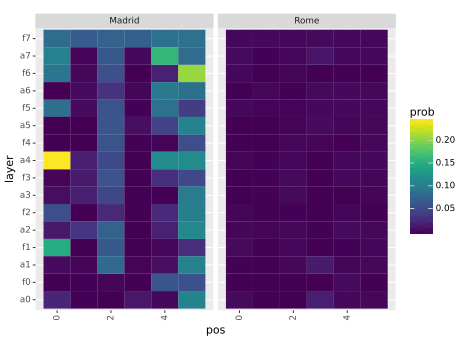

In [91]:
df['layer'] = df['layer'].astype('category')
df['token'] = df['token'].astype('category')
nodes = []
for l in range(mistral.config.num_layers - 1, -1, -1):
    nodes.append(f'f{l}')
    nodes.append(f'a{l}')
df['layer'] = pd.Categorical(df['layer'], categories=nodes[::-1], ordered=True)

g = (ggplot(df) + geom_tile(aes(x='pos', y='layer', fill='prob', color='prob')) +
     facet_wrap("~token") + theme(axis_text_x=element_text(rotation=90)))
print(g)

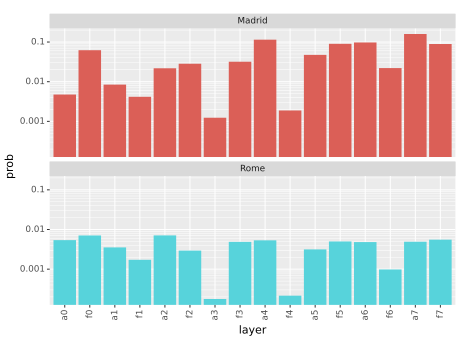

In [92]:
filtered = df
filtered = filtered[filtered['pos'] == 4]
g = (ggplot(filtered) + geom_bar(aes(x='layer', y='prob', fill='token'), stat='identity')
         + theme(axis_text_x=element_text(rotation=90), legend_position='none') + scale_y_log10()
         + facet_wrap("~token", ncol=1))
print(g)